# Extracción de datos de WaveWatch3, por regiones y períodos

Emilio Mayorga, 2022-8-19

Datos de WW3 extraídos del servidor de ERDDAP de NOAA Coastwatch. Este notebook extrae datos multidimensionales basados en la región geográfica (bounding box) y período especificados. Actualmente incluye regiones entre Estados Unidos y México (San Diego a Ensenada) y Ecuador y Perú. El notebook en estos momentos no exporta los datos extraídos a un archivo, pero sería fácil exportarlo a netcdf.

Apuntes
- Página del dataset en el ERDDAP de Coastwatch: https://coastwatch.pfeg.noaa.gov/erddap/griddap/NWW3_Global_Best.html
- La longitud de estos datos está en el formato 0 a 360 en vez de -180 a +180
- El sitio http://bboxfinder.com es muy útil para escoger el bounding box de cada región

```python
# Este funciona perfectamente
ds = xr.open_dataset("https://coastwatch.pfeg.noaa.gov/erddap/griddap/chirps20GlobalDailyP05")

# Esto deberia de funcionar, pero no funciona
ds = xr.open_dataset("https://coastwatch.pfeg.noaa.gov/erddap/griddap/NWW3_Global_Best")
```

In [1]:
import datetime
import json

import xarray as xr

from erddapy import ERDDAP

In [4]:
e = ERDDAP(
    server="CSWC",  # CoastWatch West Coast Node
    protocol="griddap",  # Protocol for gridded datasets
)

e.dataset_id = "NWW3_Global_Best" 

In [5]:
e.griddap_initialize()

In [6]:
print(f"variables in this dataset:\n\n{e.variables}")
print(
    f"\nconstraints of this dataset:\n\n{json.dumps(e.constraints, indent=1)}"
)

variables in this dataset:

['Tdir', 'Tper', 'Thgt', 'sdir', 'sper', 'shgt', 'wdir', 'wper', 'whgt']

constraints of this dataset:

{
 "time>=": "2022-08-24T18:00:00Z",
 "time<=": "2022-08-24T18:00:00Z",
 "time_step": 1,
 "depth>=": 0.0,
 "depth<=": 0.0,
 "depth_step": 1,
 "latitude>=": -77.5,
 "latitude<=": 77.5,
 "latitude_step": 1,
 "longitude>=": 0.0,
 "longitude<=": 359.5,
 "longitude_step": 1
}


Especifiquemos que variables vamos a obtener de ERDDAP, para no lidiar con todas

In [7]:
e.variables = ['shgt', 'Thgt']

Especifiquemos el periodo temporal que usaremos en común en las dos regiones

In [8]:
dt_comienzo = datetime.datetime(2021, 2, 1)
dt_final = datetime.datetime(2021, 8, 31)

In [9]:
e.constraints.update(
    {
        "time>=": f"{dt_comienzo}Z", # "2021-08-1T00:00:00Z",
        "time<=": f"{dt_final}Z", # "2021-08-31T23:00:00Z",
    }
)

In [10]:
def bounds2contraints(bounds):
    return {
        "longitude>=": bounds[0] + 360,
        "longitude<=": bounds[2] + 360,
        "latitude>=": bounds[1],
        "latitude<=": bounds[3],
    }

## Mexico - USA/California

In [11]:
mexusa_bounding_box = [-117.5, 31.5, -116.5, 33]

In [12]:
#e_mexusa = e.copy()
e_mexusa = e

In [13]:
e_mexusa.constraints.update(bounds2contraints(mexusa_bounding_box))

Ahora sí ya tenemos listas todas las constraints y variables que vamos a bajar

In [14]:
e_mexusa.constraints

{'time>=': '2021-02-01 00:00:00Z',
 'time<=': '2021-08-31 00:00:00Z',
 'time_step': 1,
 'depth>=': 0.0,
 'depth<=': 0.0,
 'depth_step': 1,
 'latitude>=': 31.5,
 'latitude<=': 33,
 'latitude_step': 1,
 'longitude>=': 242.5,
 'longitude<=': 243.5,
 'longitude_step': 1}

In [15]:
e_mexusa.variables

['shgt', 'Thgt']

In [16]:
%%time

ds_mexusa = e_mexusa.to_xarray()

CPU times: user 482 ms, sys: 21.3 ms, total: 503 ms
Wall time: 2min 51s


In [17]:
ds_mexusa

<xarray.Dataset>
Dimensions:    (time: 4877, depth: 1, latitude: 4, longitude: 3)
Coordinates:
  * time       (time) datetime64[ns] 2021-02-01 ... 2021-08-31
  * depth      (depth) float32 0.0
  * latitude   (latitude) float32 31.5 32.0 32.5 33.0
  * longitude  (longitude) float32 242.5 243.0 243.5
Data variables:
    shgt       (time, depth, latitude, longitude) float32 ...
    Thgt       (time, depth, latitude, longitude) float32 ...
Attributes: (12/68)
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    acknowledgement:               The Pacific Islands Ocean Observing System...
    cdm_data_type:                 Grid
    comment:                       Model runs produced by Kwok Fai Cheung (ch...
    Conventions:                   CF-1.6, ACDD-1.3
    creator_email:                 cheung@hawaii.edu
    ...                            ...
    testOutOfDate:                 now+105hours
    time_coverage_end:             2021-08-31T00:00:00Z
    time_coverage_resolution:      PT1H
    time_coverage_start:           2021-02-01T00:00:00Z
    title:                         WaveWatch III (WW3) Global Wave Model
    Westernmost_Easting:           242.5

Un plot geografico en uno de los time steps

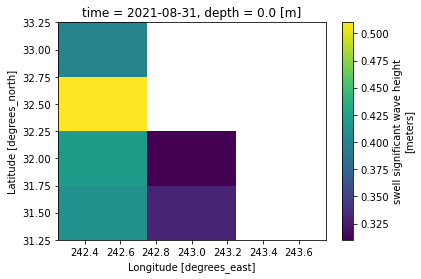

In [18]:
ds_mexusa.shgt.isel(time=-1).plot();

Un plot de la serie temporal en un pixel

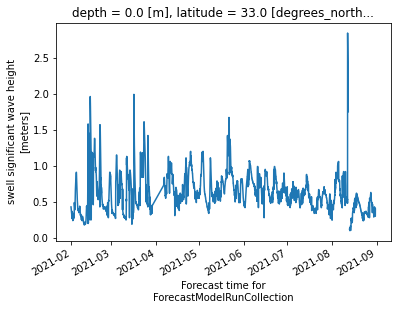

In [19]:
ds_mexusa.shgt.sel(latitude=33, longitude=242.4, method='nearest').plot();

## Peru - Ecuador

In [20]:
ecper_bounding_box = [-83, -6, -80, -2]

In [21]:
e_ecper = e

In [22]:
e_ecper.constraints.update(bounds2contraints(ecper_bounding_box))

Ahora sí ya tenemos listas todas las constraints y variables que vamos a bajar

In [23]:
e_ecper.constraints

{'time>=': '2021-02-01 00:00:00Z',
 'time<=': '2021-08-31 00:00:00Z',
 'time_step': 1,
 'depth>=': 0.0,
 'depth<=': 0.0,
 'depth_step': 1,
 'latitude>=': -6,
 'latitude<=': -2,
 'latitude_step': 1,
 'longitude>=': 277,
 'longitude<=': 280,
 'longitude_step': 1}

In [24]:
%%time

ds_ecper = e_ecper.to_xarray()

CPU times: user 97.4 ms, sys: 16.6 ms, total: 114 ms
Wall time: 2min 59s


In [25]:
ds_ecper

<xarray.Dataset>
Dimensions:    (time: 4877, depth: 1, latitude: 9, longitude: 7)
Coordinates:
  * time       (time) datetime64[ns] 2021-02-01 ... 2021-08-31
  * depth      (depth) float32 0.0
  * latitude   (latitude) float32 -6.0 -5.5 -5.0 -4.5 -4.0 -3.5 -3.0 -2.5 -2.0
  * longitude  (longitude) float32 277.0 277.5 278.0 278.5 279.0 279.5 280.0
Data variables:
    shgt       (time, depth, latitude, longitude) float32 ...
    Thgt       (time, depth, latitude, longitude) float32 ...
Attributes: (12/68)
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    acknowledgement:               The Pacific Islands Ocean Observing System...
    cdm_data_type:                 Grid
    comment:                       Model runs produced by Kwok Fai Cheung (ch...
    Conventions:                   CF-1.6, ACDD-1.3
    creator_email:                 cheung@hawaii.edu
    ...                            ...
    testOutOfDate:                 now+105hours
    time_coverage_end:             2021-08-31T00:00:00Z
    time_coverage_resolution:      PT1H
    time_coverage_start:           2021-02-01T00:00:00Z
    title:                         WaveWatch III (WW3) Global Wave Model
    Westernmost_Easting:           277.0

Un plot geografico en uno de los time steps

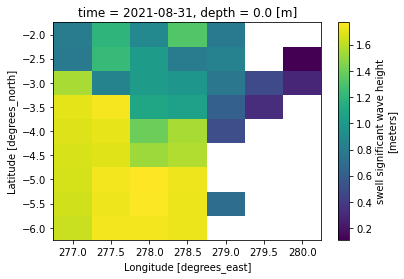

In [26]:
ds_ecper.shgt.isel(time=-1).plot();

Un plot de la serie temporal en un pixel

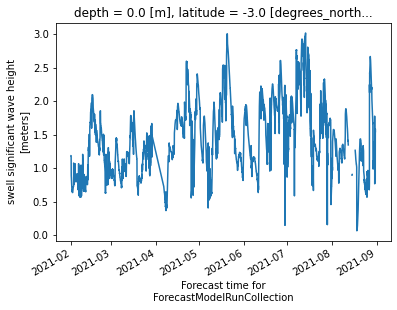

In [27]:
ds_ecper.shgt.sel(latitude=-3, longitude=277, method='nearest').plot();